# Simulate and plot logical measurement of a dual-rail cavity qubit via repeated photon number parity measurements

In [1]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
mpl.rcParams['figure.facecolor'] = 'white' 
%matplotlib inline
options = qp.Options()
options.num_cpus = 3
options.atol = 1e-12
options.rtol = 1e-12
options.tidy = True
options.method = 'adams'

In [2]:
#units
ms = 1e-3
us = 1e-6
ns = 1e-9

MHz = 1e6
kHz = 1e3
twopi = 2*np.pi
r2 = np.sqrt(2)

### Define operators, tensor spaces, states

In [3]:
d = 3
d_q = 2

a = qp.destroy(d)
q = qp.destroy(d_q)
eye = qp.tensor(qp.qeye(d),qp.qeye(d),qp.qeye(d_q))

a1 = qp.tensor(a,qp.qeye(d),qp.qeye(d_q))
a2 = qp.tensor(qp.qeye(d),a,qp.qeye(d_q))
q1 = qp.tensor(qp.qeye(d),qp.qeye(d),q)


g = qp.fock(d_q,0)
e = qp.fock(d_q,1)

gpe = (g+e).unit()
gme = (g-e).unit()
SWAP_cav = (1j*np.pi/2.*(a1.dag()*a2+a1*a2.dag())).expm()

Had = g*gpe.dag()+e*gme.dag()#+f_level*f_level.dag()
Xge = qp.fock(d_q,0)*qp.fock(d_q,1).dag()+qp.fock(d_q,1)*qp.fock(d_q,0).dag()

Had1 = qp.tensor(qp.qeye(d),qp.qeye(d),Had)

ee1 = qp.tensor(qp.qeye(d),qp.qeye(d),qp.fock(d_q,1)*qp.fock(d_q,1).dag())

eg1 = qp.tensor(qp.qeye(d),qp.qeye(d),qp.fock(d_q,0)*qp.fock(d_q,1).dag())

CPS_pi = (1j*np.pi*a1.dag()*a1*ee1).expm()

proj_g = qp.tensor(qp.qeye(d),qp.qeye(d),qp.fock(d_q,0)*qp.fock(d_q,0).dag())
proj_e = qp.tensor(qp.qeye(d),qp.qeye(d),qp.fock(d_q,1)*qp.fock(d_q,1).dag())
pi_flip = qp.tensor(qp.qeye(d),qp.qeye(d),qp.fock(d_q,0)*qp.fock(d_q,1).dag()+qp.fock(d_q,1)*qp.fock(d_q,0).dag())

### Hamiltonian parameters

In [4]:
chi1 = -2*twopi*MHz
chi2 = chi1

t_p = np.abs(np.pi/chi1)
tlist_p = np.linspace(0,t_p,1001)
H_disp = chi1*a1.dag()*a1*ee1

### Define collapse operators: transmon decay, transmon dephasing, transmon heating, cavity decay, cavity dephasing, cavity heating

In [5]:
Tphi_q = 100*us
T1_q = 100*us
Theat_q = T1_q*100
T1_c = 1000*us
Theat_c = T1_c*100
c_ops_qs = [np.sqrt(1/T1_q)*q1,np.sqrt(2/Tphi_q)*q1.dag()*q1,np.sqrt(1/Theat_q)*q1.dag()]


c_ops_cs = [np.sqrt(1/T1_c)*a1,np.sqrt(1/T1_c)*a2,np.sqrt(Theat_c)*a1.dag(),np.sqrt(Theat_c)*a2.dag()]
c_ops = c_ops_qs + c_ops_cs

In [41]:
perfect_msmt = False #set whether we model errors during transmon readout, need to run code twice with this true and false to recreate the full plot

In [42]:
def scramble_msmt(rho_in,p_d = 0,p_o = 0): #transmon readout error model: includes transmon decay during readout and overlap error
    rho_g = (proj_g*rho_in*proj_g).ptrace((0,1))
    rho_e = (proj_e*rho_in*proj_e).ptrace((0,1))
    rho_Mg = qp.tensor((1-p_o)*rho_g+p_d/2.*rho_e,g*g.dag()) + qp.tensor(p_o*rho_e,e*e.dag())
    rho_Me = qp.tensor((1-p_o-p_d)*rho_e,e*e.dag())+qp.tensor(p_o*rho_g+p_d/2.*rho_e,g*g.dag())
    return rho_Mg, pi_flip*rho_Me*pi_flip #perfect conditional reset

In [43]:
def gen_rho_outcomes(state_init,p_d,p_o):#sequence for a single parity msmt, swaps the cavity states and has a 1us delay too
    rho_Had = Had1*state_init*Had1.dag()
    res1 = qp.mesolve(H_disp,rho_Had,tlist_p,c_ops = c_ops, options = options)
    rho1_ = SWAP_cav*Had1*res1.states[-1]*Had1.dag()*SWAP_cav.dag()
    if not perfect_msmt:
        res1_wait  = qp.mesolve(H_disp-H_disp,rho1_,tlist = np.linspace(0,1*us,101), c_ops = c_ops_cs, options = options)
        rho1 = res1_wait.states[-1]
    else:
        rho1 = rho1_
    rho_Mg1, rho_Me1 = scramble_msmt(rho1,p_d,p_o)
    return rho_Mg1, rho_Me1

def get_rhos(state_init,p_d,p_o):
    if state_init.type == 'ket':
        state_init = qp.ket2dm(state_init)
    #1st parity msmt
    rho_Mg1, rho_Me1 = gen_rho_outcomes(state_init,p_d,p_o)
    #2nd parity msmt
    #if first outcome g
    rho_Mgg, rho_Mge = gen_rho_outcomes(rho_Mg1,p_d,p_o)
    #if first outcome e
    rho_Meg, rho_Mee = gen_rho_outcomes(rho_Me1,p_d,p_o)
    return rho_Mgg,rho_Mge,rho_Meg,rho_Mee

def get_probs(state_init,p_d,p_o):
    rho_Mgg,rho_Mge,rho_Meg,rho_Mee = get_rhos(state_init,p_d,p_o)
    return rho_Mgg.tr(),rho_Mge.tr(),rho_Meg.tr(),rho_Mee.tr()
    
    

# Test for one msmt round (parity msmt + transmon readout) x2 for each cavity

In [44]:
psi_init = qp.tensor(qp.fock(d,1),qp.fock(d,0),g)
rho_Mgg,rho_Mge,rho_Meg,rho_Mee = get_rhos(psi_init, p_d = 0.01, p_o = 1e-4)

In [45]:
print('p_gg:',rho_Mgg.tr())
print('p_ge:',rho_Mge.tr())
print('p_eg:',rho_Meg.tr())
print('p_ee:',rho_Mee.tr())

p_gg: 0.0069789850495877255
p_ge: 0.00011286533459096542
p_eg: 0.9860084238575754
p_ee: 0.006899725754860283


# Define functions for simulating 1 or 2 Rounds of DR logical msmt

In [46]:
def get_1R_vals(psi_init,p_d,p_o):
    rho_gg,rho_ge,rho_eg,rho_ee = get_rhos(psi_init,p_d,p_o) 
    p_gg = (rho_gg).tr()
    p_ge = (rho_ge).tr()
    p_ee = (rho_ee).tr()
    p_eg = (rho_eg).tr()
    return np.array([p_ge,p_eg,p_gg+p_ee])

def get_2R_vals(state_init, p_d, p_o):    
    rho_gg,rho_ge,rho_eg,rho_ee = get_rhos(state_init, p_d, p_o)
    p_gg, p_ge, p_eg, p_ee = get_probs(state_init, p_d, p_o)
    p_gggg, p_ggge, p_ggeg, p_ggee   = get_probs(rho_gg, p_d, p_o)
    p_eegg, p_eege, p_eeeg, p_eeee   = get_probs(rho_ee, p_d, p_o)    
    p_gegg, p_gege, p_geeg, p_geee   = get_probs(rho_ge, p_d, p_o)
    p_eggg, p_egge, p_egeg, p_egee   = get_probs(rho_eg, p_d, p_o)
    return np.array([p_ge+p_ggge+p_eege,p_eg+p_ggeg+p_eeeg,(1-(p_ge+p_ggge+p_eege+p_eg+p_ggeg+p_eeeg))])

def get_2R_vals_strict(state_init, p_d, p_o):
    rho_gg,rho_ge,rho_eg,rho_ee = get_rhos(state_init, p_d, p_o)
    p_gg, p_ge, p_eg, p_ee = get_probs(state_init, p_d, p_o)
    p_gggg, p_ggge, p_ggeg, p_ggee   = get_probs(rho_gg, p_d, p_o)
    p_eegg, p_eege, p_eeeg, p_eeee   = get_probs(rho_ee, p_d, p_o)    
    p_gegg, p_gege, p_geeg, p_geee   = get_probs(rho_ge, p_d, p_o)
    p_eggg, p_egge, p_egeg, p_egee   = get_probs(rho_eg, p_d, p_o)
    return np.array([p_gege,p_egeg,(1-(p_gege+p_egeg))])

# Define function for simulating 3 rounds of msmt

In [47]:
def get_string_prob(string,rho_listss):
    if string[0:2] == 'gg':
        idx1 = 0
    if string[0:2] == 'eg':
        idx1 = 1
    if string[0:2] == 'ge':
        idx1 = 2
    if string[0:2] == 'ee':
        idx1 = 3
        
    if string[2:4] == 'gg':
        idx2 = 0
    if string[2:4] == 'eg':
        idx2 = 1
    if string[2:4] == 'ge':
        idx2 = 2
    if string[2:4] == 'ee':
        idx2 = 3
        
    if string[4:6] == 'gg':
        idx3 = 0
    if string[4:6] == 'eg':
        idx3 = 1
    if string[4:6] == 'ge':
        idx3 = 2
    if string[4:6] == 'ee':
        idx3 = 3
        
    return rho_listss[idx1][idx2][idx3].tr()

def get_strings_prob(string_list,rho_listss):
    ptot = 0
    for string in string_list:
        ptot+=get_string_prob(string,rho_listss)
    return ptot
        
def invert_string(string):
    intermediate = string.replace('g','0').replace('e','1')
    final = intermediate.replace('0','e').replace('1','g')
    return final
def invert_strings(string_list):
    temp_list = []
    for string in string_list:
        temp_list.append(invert_string(string))
    return temp_list

#sorted possible msmt outcome strings
perfect_10 = ['egegeg']
error_1_10 = ['ggegeg','egggeg','egeggg','eeegeg','egeeeg','egegee']
error_2_10 = ['geegeg','ggeeeg','ggegee','eeggeg','eggeeg','egggee','eeeggg','egeegg','egegge']
all_10 = perfect_10+error_1_10+error_2_10
all_01 = invert_strings(all_10)

def get_3R_vals(psi_init, p_d,p_o):
    #layer 1
    print('3R Round 1')
    rho_list1 = get_rhos(psi_init,p_d,p_o)
    #layer2
    rho_lists_2 = []
    print('3R Round 2')
    for rho in rho_list1:
        rho_list2 = get_rhos(rho,p_d,p_o)
        rho_lists_2.append(rho_list2)
    #layer3
    print('3R Round 3')
    rho_listss_3 = []
    for rho_list in rho_lists_2:
        rho_lists_3 = []
        for rho in rho_list:
            rho_list3 = get_rhos(rho,p_d,p_o)
            rho_lists_3.append(rho_list3)
        rho_listss_3.append(rho_lists_3)
    #prob 10 declared
    p_10 = get_strings_prob(all_10,rho_listss_3)
    #prob 01 declared
    p_01 = get_strings_prob(all_01,rho_listss_3)
    return([p_10,p_01,(1-p_10-p_01)])

In [48]:
def get_mat(val_func,kwargs): #decoded logical msmt outcomes stored as matrix for the 3 possible input states: |10>, |01> and |00> 
    psi_10 = qp.tensor(qp.fock(d,1),qp.fock(d,0),g)
    psi_01 = qp.tensor(qp.fock(d,0),qp.fock(d,1),g)
    psi_00 = qp.tensor(qp.fock(d,0),qp.fock(d,0),g)
    row10 = val_func(psi_10,**kwargs)
    row01 = val_func(psi_01,**kwargs)
    row00 = val_func(psi_00,**kwargs)
    return np.array([row01,row10,row00])

# Generate data

In [49]:
# set readout errors
if perfect_msmt:
    p_d = 0
    p_o = 0
else:
    p_d = 0.01
    p_o = 1e-4
    
p_erasure = 0.01 #probability input state is |00> (probability of |10> is (1-p_erasure)/2 etc.)


In [50]:
#1 Round
mat_1R = get_mat(get_1R_vals,{'p_d':p_d, 'p_o':p_o})
print('1 round msmt matrix')
print(mat_1R)

1 round msmt matrix
[[9.89718245e-01 1.24320871e-04 1.01574339e-02]
 [1.12865335e-04 9.86008424e-01 1.38787108e-02]
 [1.96440039e-03 1.85586541e-03 9.96179734e-01]]


In [51]:
#2 Round
mat_2R = get_mat(get_2R_vals,{'p_d':p_d, 'p_o':p_o})
print('2 round msmt matrix')
print(mat_2R)
mat_2R_s = get_mat(get_2R_vals_strict,{'p_d':p_d, 'p_o':p_o})
print('2 round msmt matrix (strict decoding)')
print(mat_2R_s)

2 round msmt matrix
[[9.98302380e-01 1.29514506e-04 1.56810504e-03]
 [1.14969402e-04 9.99408080e-01 4.76950877e-04]
 [3.92140585e-03 3.70579421e-03 9.92372800e-01]]
2 round msmt matrix (strict decoding)
[[9.73556293e-01 2.27647539e-08 2.64436842e-02]
 [1.59832333e-08 9.69909221e-01 3.00907626e-02]
 [3.79098807e-06 3.46782374e-06 9.99992741e-01]]


In [52]:
mat_3R = get_mat(get_3R_vals,{'p_d':p_d, 'p_o':p_o})
print(mat_3R)
print('3 round msmt matrix (majority vote decoding)')

3R Round 1
3R Round 2
3R Round 3
3R Round 1
3R Round 2
3R Round 3
3R Round 1
3R Round 2
3R Round 3
[[9.95881897e-01 2.27056754e-07 4.11787550e-03]
 [2.21960605e-07 9.97059629e-01 2.94014927e-03]
 [1.42864622e-05 1.37099928e-05 9.99972004e-01]]
3 round msmt matrix (majority vote decoding)


In [53]:
def get_erasure_prob(mat,p_erasure):    
    return (1-p_erasure)/2.*(mat[0][2]+mat[1][2]) + p_erasure*mat[2][2]
def get_pauli_prob(mat,p_erasure):    
    return (1-p_erasure)/2.*(mat[0][1]+mat[1][0]) + p_erasure*(mat[2][0]+mat[2][1])

In [54]:
#p_erasure_R = probability erasure declared in the msmt outcome
#p_pauli_R = probability we assign the opposite logical state e.g. assign |10> when input was |01> and vice versa
p_erase_1R = get_erasure_prob(mat_1R,p_erasure)
p_erase_2R = get_erasure_prob(mat_2R,p_erasure)
p_erase_2R_s = get_erasure_prob(mat_2R_s,p_erasure)
p_erase_3R = get_erasure_prob(mat_3R,p_erasure)

p_pauli_1R = get_pauli_prob(mat_1R,p_erasure)
p_pauli_2R = get_pauli_prob(mat_2R,p_erasure)
p_pauli_2R_s = get_pauli_prob(mat_2R_s,p_erasure)
p_pauli_3R = get_pauli_prob(mat_3R,p_erasure)

In [55]:
p_paulis = [p_pauli_1R,p_pauli_2R,p_pauli_2R_s,p_pauli_3R]
p_erases = [p_erase_1R,p_erase_2R,p_erase_2R_s,p_erase_3R]

In [56]:
#gen data with perfect_msmt = True, then store it here
if perfect_msmt:
    print('setting perfect msmt vals')
    no_RO_error_1R = [p_erase_1R-p_erasure, p_pauli_1R]
    no_RO_error_2R = [p_erase_2R-p_erasure, p_pauli_2R]
    no_RO_error_2R_s = [p_erase_2R_s-p_erasure, p_pauli_2R_s]
    no_RO_error_3R = [p_erase_3R-p_erasure, p_pauli_3R]

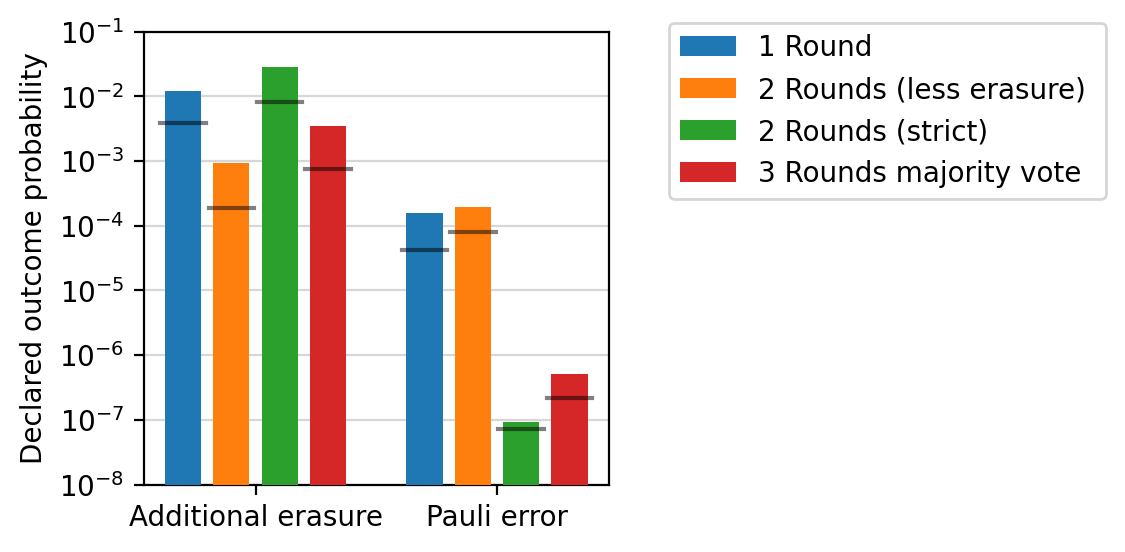

In [57]:
#plotting additional erasure error,
fig, ax = plt.subplots(dpi = 200, figsize = (3,3))
x_axis_labes = ['erasure','pauli error']
xs = np.array([0,1])
width = 0.15
bar_spacing = 0.2
ax.grid(alpha = 0.5,axis = 'y', zorder = 0)
ax.bar(xs-1.5*bar_spacing,[p_erase_1R-p_erasure,p_pauli_1R],width = width,label = '1 Round', zorder = 3) #plotting the additional erasure prob
ax.bar(xs-0.5*bar_spacing,[p_erase_2R-p_erasure,p_pauli_2R],width = width, label = '2 Rounds (less erasure) ', zorder = 3)
ax.bar(xs+0.5*bar_spacing,[p_erase_2R_s-p_erasure,p_pauli_2R_s],width = width, label = '2 Rounds (strict)', zorder = 3)
ax.bar(xs+1.5*bar_spacing,[p_erase_3R-p_erasure,p_pauli_3R],width = width, label = '3 Rounds majority vote', zorder = 3)
ax.set_yscale('log')
ax.set_ylabel('Declared outcome probability')
ax.set_yticks([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
ax.set_ylim(1e-8,1e-1)
ax.set_xticks([0,1])
ax.set_xticklabels(['Additional erasure','Pauli error'])

#gen data with perfect_msmt = True to plot the following
try:
    overhang = 0.01
    ax.axhline(y = no_RO_error_1R[0],xmin = 0.0454545-overhang, xmax = 0.12337+overhang, ls = '-',color = 'k', alpha = 0.5, zorder = 4)
    ax.axhline(y = no_RO_error_2R[0],xmin = 0.149350-overhang, xmax = 0.2272727+overhang, ls = '-',color = 'k', alpha = 0.5, zorder = 4)
    ax.axhline(y = no_RO_error_2R_s[0],xmin = 0.253246-overhang, xmax =0.331168+overhang, ls = '-',color = 'k', alpha = 0.5, zorder = 4)
    ax.axhline(y = no_RO_error_3R[0],xmin = 0.357142-overhang, xmax = 0.435064+overhang, ls = '-',color = 'k', alpha = 0.5, zorder = 4)
    ax.axhline(y = no_RO_error_1R[1],xmin = 0.0454545+0.519480-overhang, xmax = 0.12337+0.519480+overhang, ls = '-',color = 'k', alpha = 0.5, zorder = 4)
    ax.axhline(y = no_RO_error_2R[1],xmin =0.149350+0.519480-overhang, xmax = 0.22727+0.519480+overhang, ls = '-',color = 'k', alpha = 0.5, zorder = 4)
    ax.axhline(y = no_RO_error_2R_s[1],xmin = 0.253246+0.519480-overhang, xmax = 0.33116+0.519480+overhang, ls = '-',color = 'k', alpha = 0.5, zorder = 4)
    ax.axhline(y = no_RO_error_3R[1],xmin = 0.357142+0.519480-overhang, xmax = 0.435064+0.519480+overhang, ls = '-',color = 'k', alpha = 0.5, zorder = 4)
except:
    print('no data with perfect_msmt found')

ax.legend(bbox_to_anchor=(1.1, 1.05))

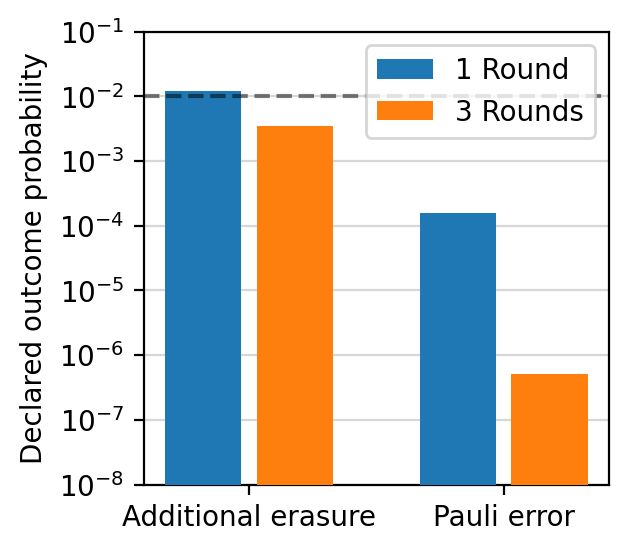

In [58]:
#plot for 1 round and 3 round only
fig, ax = plt.subplots(dpi = 200, figsize = (3,3))
x_axis_labes = ['additional erasure','pauli error']
xs = np.array([0,1])
width = 0.3
bar_scaling = 0.6
ax.grid(alpha = 0.5,axis = 'y', zorder = 0)
ax.bar(xs-width*bar_scaling,[p_erase_1R-p_erasure,p_pauli_1R],width = width,label = '1 Round', zorder = 3)
ax.bar(xs+width*bar_scaling,[p_erase_3R-p_erasure,p_pauli_3R],width = width, label = '3 Rounds', zorder = 3)
ax.set_yscale('log')
ax.set_ylim(1e-8,1e-1)
ax.set_ylabel('Declared outcome probability')
ax.set_xticks(xs)
ax.set_yticks([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
ax.set_xticklabels([' ',' '])
ax.axhline(p_erasure,ls = '--', color = 'k', alpha = 0.5, zorder = 4)
ax.set_xticks([0,1])
ax.set_xticklabels(['Additional erasure','Pauli error'])
ax.legend()